In [1]:
import os
import numpy as np
import pandas as pd
from pathlib import Path
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
sns.set()
sns.set_style("whitegrid")

DPI = 200
plt.rcParams['figure.dpi'] = DPI
plt.rcParams['figure.figsize'] = (5,3.5)

In [3]:
DATASET = 'AOF'
# Adult, COMPAS, Donors Choose, AOF

**^ pick dataset here! ^**

# Load Data

In [4]:
ROOT_DIR = Path('..')
ALL_AGGREGATED_RESULTS = ROOT_DIR / 'data' / 'results_all_datasets.csv'
ALL_TUNER_ITERATIONS = ROOT_DIR / 'data' / f'all_tuner_iters_evals_{DATASET}.csv.gz'

In [5]:
all_tuner_iters_evals = pd.read_csv(ALL_TUNER_ITERATIONS)

In [6]:
results_df = pd.read_csv(ALL_AGGREGATED_RESULTS)

# Discard RandomSampler results (duplicated with RandomSearch)
results_df = results_df[results_df['task_type'] != 'RandomSampler']

In [7]:
key_columns = ['dataset', 'task_type', 'alpha']
metric_columns = ['performance_val', 'fairness_val', 'performance_test', 'fairness_test']

results_df_metrics = results_df[key_columns + metric_columns + ['model_classpath', 'tuner']]

In [8]:
# Keep results for current dataset only
results_df = results_df[results_df['dataset'] == DATASET]
results_df_metrics = results_df_metrics[results_df_metrics['dataset'] == DATASET]

N_RUNS = 15
assert len(results_df) == N_RUNS * 7

# Dataset configs

In [9]:
DATASET_TO_CONFIGS = {
    'Adult': {
        'performance': 'precision',
        'fairness': 'sex_min_tpr_disparity',
        'fairness_label': 'equal opportunity',
        'target_threshold': 'tpr = 50',
    },
    'COMPAS': {
        'performance': 'precision',        
        'fairness': 'race_Caucasian_min_fpr_disparity',
        'fairness_label': 'predictive equality',
        'target_threshold': 'fpr = 10',
    },
    'Donors Choose': {
        'performance': 'precision',
        'fairness': 'poverty_level_min_tpr_disparity',
        'fairness_label': 'equal opportunity',
        'target_threshold': 'pp = 1000',
    },
    'AOF': {
        'performance': 'recall',
        'fairness': 'age_min_fpr_disparity',
        'fairness_label': 'predictive equality',
        'target_threshold': 'fpr = 5',
    },
}

assert DATASET in DATASET_TO_CONFIGS.keys()

In [10]:
CONFIGS = DATASET_TO_CONFIGS[DATASET]

PERFORMANCE_METRIC = CONFIGS['performance']
PERFORMANCE_LABEL = CONFIGS.get('performance_label', PERFORMANCE_METRIC)
PERFORMANCE_LABEL = f"predictive accuracy ({PERFORMANCE_LABEL})"

FAIRNESS_METRIC = CONFIGS['fairness']
FAIRNESS_LABEL = CONFIGS.get('fairness_label', FAIRNESS_METRIC)
FAIRNESS_LABEL = f"fairness ({FAIRNESS_LABEL})"

In [11]:
IMGS_DIR = ROOT_DIR / 'imgs' / DATASET
os.makedirs(IMGS_DIR, exist_ok=True)

# Plotting

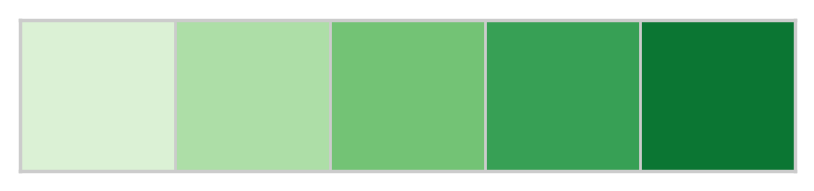

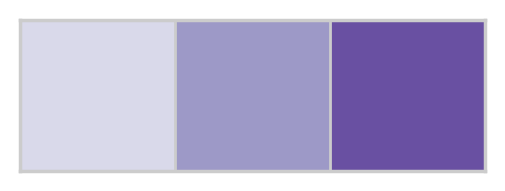

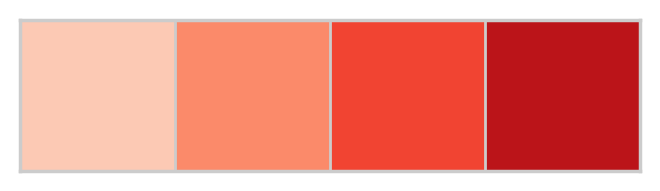

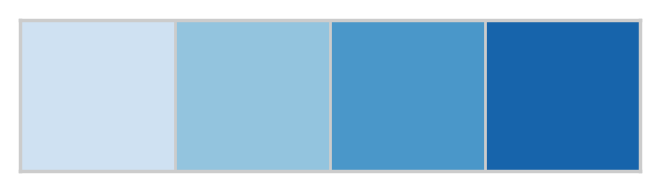

In [12]:
algo_colors = {}

palette = sns.color_palette("Greens", n_colors=5)
sns.palplot(palette)
algo_colors['FB'] = palette[2]
algo_colors['FB-auto'] = palette[4]

# Hyperband
palette = sns.color_palette("Purples", n_colors=3)
sns.palplot(palette)
algo_colors['HB'] = palette[2]

# Random Search
palette = sns.color_palette("Reds", n_colors=4)
sns.palplot(palette)
algo_colors['FairRS'] = palette[1]
algo_colors['RS'] = palette[3]

# TPE
palette = sns.color_palette("Blues", n_colors=4)
sns.palplot(palette)
algo_colors['FairTPE'] = palette[1]
algo_colors['TPE'] = palette[3]

In [13]:
from matplotlib.lines import Line2D

def add_custom_legend(axes, values, palette, **kwargs) -> None:
    legend_kwargs = {
        'bbox_to_anchor' : (0.5, 1),
        'loc'            : 'lower center',
        'ncol'           : 4,
        'borderaxespad'  : 0.,
        'handletextpad'  : 0.1,
        'columnspacing'  : 0.1,
        'frameon'        : False,
        'labelspacing'   : 0,
    }
    legend_kwargs.update(kwargs)
    
    if isinstance(palette, dict):
        color_legend = [Line2D([0], [0], lw=0, marker='o', color=palette[val], label=val) for val in values], values
    else:
        color_legend = [Line2D([0], [0], lw=0, marker='o', color=palette[i], label=val) for i, val in enumerate(values)], values

    handles, labels = axes.get_legend_handles_labels()
    color_leg = axes.legend(*color_legend, **legend_kwargs)

    axes.add_artist(color_leg)

## Fairness vs. Accuracy, discriminated by _Hyperparameter Tuner_
- for use w/ **all datasets**

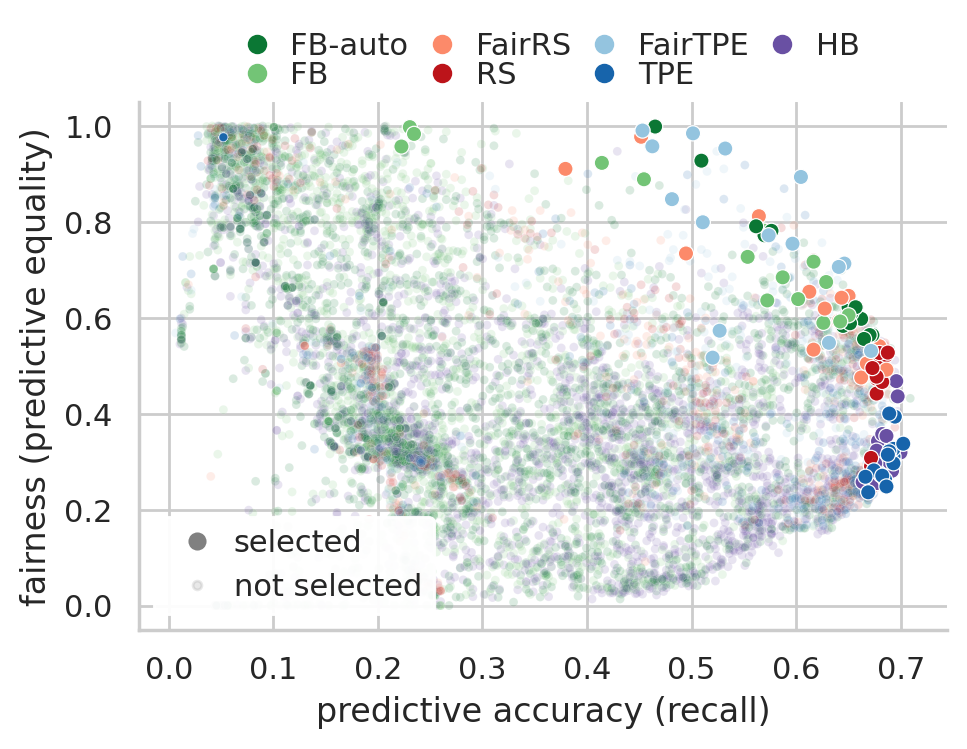

In [14]:
selected_models = results_df_metrics
other_models = all_tuner_iters_evals

hue = 'tuner'
matrix_type = 'val'

LARGE_ALPHA = 1
SMALL_ALPHA = 0.15

LARGE_POINTS = 30
SMALL_POINTS = 10

perf_metric = f'performance_{matrix_type}'
fair_metric = f'fairness_{matrix_type}'

if hue:
    labels = ['FB-auto', 'FB', 'FairRS', 'RS', 'FairTPE', 'TPE', 'HB']
    hue_args = {
        "hue": hue,
        "hue_order": labels,
        "palette": algo_colors,
    }


# Plot background models
ax = sns.scatterplot(
    data=other_models,
    x=perf_metric, 
    y=fair_metric,
    s=SMALL_POINTS,
    alpha=SMALL_ALPHA,
    **hue_args,
)

# Plot foreground models
ax = sns.scatterplot(
    data=selected_models,
    x=perf_metric, 
    y=fair_metric,
    s=LARGE_POINTS,
    alpha=LARGE_ALPHA,
    ax=ax,
    **hue_args,
)

add_custom_legend(ax, labels, algo_colors)


# Legend for point sizes
leg_color = 'grey'
marker_big = Line2D([0], [0], lw=0, marker='o', color=leg_color, markersize=(LARGE_POINTS ** (1/2)))
marker_small = Line2D([0], [0], lw=0, marker='o', color=leg_color, markersize=(SMALL_POINTS ** (1/2)), alpha=SMALL_ALPHA)

size_legend = ax.axes.legend(
    (marker_big, marker_small), ('selected', 'not selected'),
    loc = 'lower left',
    frameon=True,
    handletextpad=0.2,
    #borderpad=0.,
    edgecolor='white',
)
ax.axes.add_artist(size_legend)

plt.gcf().tight_layout()
sns.despine()

plt.xlabel(PERFORMANCE_LABEL)
plt.ylabel(FAIRNESS_LABEL)

if DATASET == 'Adult':
    plt.ylim(0.4, 1.01)
    plt.xlim(0.7, 1.01)
if DATASET == 'Donors Choose':
    plt.ylim(0.05, 1.02)
    plt.xlim(0.3, 0.65)


path = IMGS_DIR / f'{DATASET}_fairness_performance_selected_by_{hue}.png'
plt.gcf().savefig(path, dpi=DPI, bbox_inches="tight")

plt.show()

In [15]:
sel_fb_models = results_df_metrics[results_df_metrics['tuner'] == 'FB-auto']
sel_fb_models = sel_fb_models[['performance_val', 'fairness_val', 'model_classpath']]

other_fb_models = all_tuner_iters_evals[all_tuner_iters_evals['tuner'] == 'FB-auto']
other_fb_models = other_fb_models[['performance_val', 'fairness_val', 'model_classpath']]

classpath_to_model_type = {
    'fairautoml.nn.wrappers.FeedForwardClassifier': 'NN',
    'lightgbm.LGBMClassifier': 'LGBM',
    'sklearn.tree.DecisionTreeClassifier': 'DT',
    'sklearn.linear_model.LogisticRegression': 'LR',
    'sklearn.ensemble.RandomForestClassifier': 'RF',
    'fairautoml.utils.wrappers.FairLearnClassifier': 'EG',
}

sel_fb_models['model'] = sel_fb_models['model_classpath'].apply(
    lambda val: classpath_to_model_type[val]
)
other_fb_models['model'] = other_fb_models['model_classpath'].apply(
    lambda val: classpath_to_model_type[val]
)

ml_model_types = ['DT', 'EG', 'LGBM', 'LR', 'NN', 'RF']
palette = {model_type: color for (model_type, color) in zip(ml_model_types, sns.color_palette(n_colors=len(ml_model_types)))}
palette

{'DT': (0.2980392156862745, 0.4470588235294118, 0.6901960784313725),
 'EG': (0.8666666666666667, 0.5176470588235295, 0.3215686274509804),
 'LGBM': (0.3333333333333333, 0.6588235294117647, 0.40784313725490196),
 'LR': (0.7686274509803922, 0.3058823529411765, 0.3215686274509804),
 'NN': (0.5058823529411764, 0.4470588235294118, 0.7019607843137254),
 'RF': (0.5764705882352941, 0.47058823529411764, 0.3764705882352941)}

## Fairness vs. Accuracy, discriminated by _Model Type_
- for use w/ AOF dataset
- Adult dataset data is in GitHub notebooks

In [16]:
# Include the EG experiment data for the plot by model type!
if DATASET == 'AOF':
    sel_models_aof = pd.read_csv(ROOT_DIR / 'data' / 'AOF-EG-experiment_non-aggregated-results.csv')
    sel_fb_models = sel_models_aof[sel_models_aof['tuner'] == 'FB']

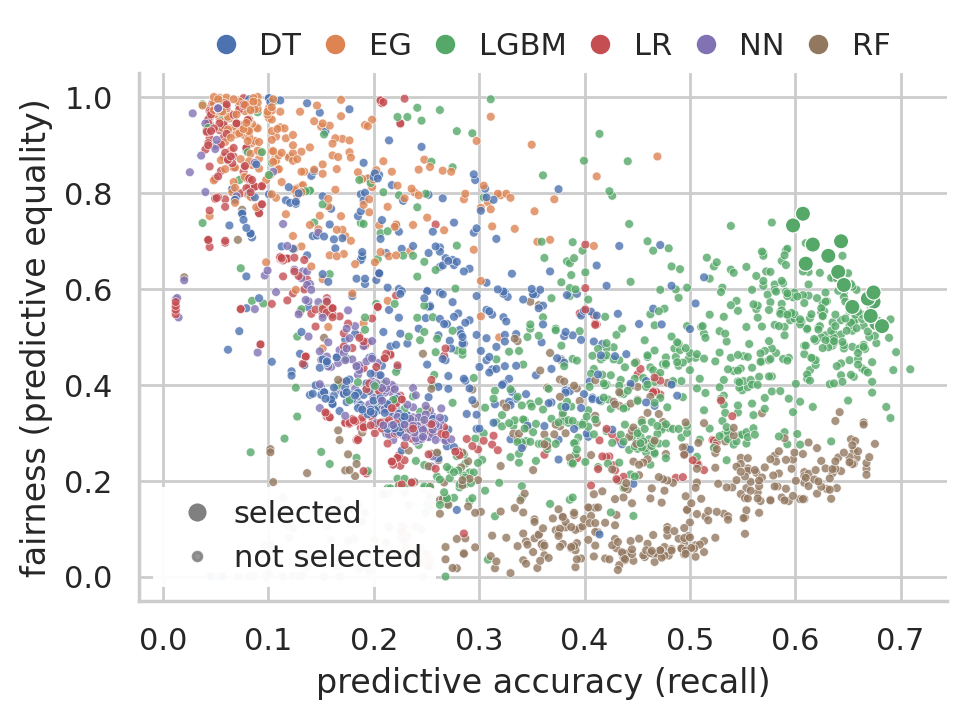

In [17]:
labels = sorted(list(other_fb_models['model'].unique()))
curr_palette = {model: palette[model] for model in labels}

perf_metric = f'performance_{matrix_type}'
fair_metric = f'fairness_{matrix_type}'

SMALL_ALPHA = 0.8

hue_args = {
    "hue": 'model',
    "hue_order": labels,
    "palette": curr_palette,
}

# Plot background models
ax = sns.scatterplot(
    data=other_fb_models,
    x=perf_metric, 
    y=fair_metric,
    s=SMALL_POINTS,
    alpha=SMALL_ALPHA,
    **hue_args,
)

# Plot foreground models
ax = sns.scatterplot(
    data=sel_fb_models,
    x=perf_metric, 
    y=fair_metric,
    s=LARGE_POINTS,
    alpha=LARGE_ALPHA,
    ax=ax,
    **hue_args,
)

add_custom_legend(ax, labels, palette, ncol=len(labels))

# Legend for point sizes
leg_color = 'grey'
marker_big = Line2D([0], [0], lw=0, marker='o', color=leg_color, markersize=(LARGE_POINTS ** (1/2)))
marker_small = Line2D([0], [0], lw=0, marker='o', color=leg_color, markersize=(SMALL_POINTS ** (1/2)), alpha=SMALL_ALPHA)

size_legend = ax.axes.legend(
    (marker_big, marker_small), ('selected', 'not selected'),
    loc = 'lower left',
    frameon=True,
    handletextpad=0.2,
    #borderpad=0.,
    edgecolor='white',
)
ax.axes.add_artist(size_legend)

plt.gcf().tight_layout()
sns.despine()

plt.xlabel(PERFORMANCE_LABEL)
plt.ylabel(FAIRNESS_LABEL)

path = IMGS_DIR / f'{DATASET}_fairness_performance_selected_by_model_type.png'
plt.gcf().savefig(path, dpi=DPI, bbox_inches="tight")

plt.show()

## Fairness vs. Accuracy, general trade-off plot (to show convexity)
- for use w/ **all but Adult dataset**

In [18]:
models_at_full_budget = all_tuner_iters_evals[all_tuner_iters_evals['eta_exp'] == 0][
    ['tuner', 'performance_val', 'fairness_val']
]
assert len(models_at_full_budget) == N_RUNS * 10 * 3 + N_RUNS * 24 * 4
# 10 full budget models per bandit-based tuner (3 tuners), 24 full budget models per TPE/RS tuner (4 tuners)

In [19]:
# Fairly fast for many datapoints, less fast for many costs, somewhat readable
def is_pareto_efficient(costs):
    """
    Find the pareto-efficient points
    :param costs: An (n_points, n_costs) array
    :return: A (n_points, ) boolean array, indicating whether each point is Pareto efficient
    """
    is_efficient = np.ones(costs.shape[0], dtype = bool)
    for i, c in enumerate(costs):
        if is_efficient[i]:
            is_efficient[is_efficient] = np.any(costs[is_efficient]<c, axis=1)  # Keep any point with a lower cost
            is_efficient[i] = True  # And keep self
    return is_efficient

In [20]:
# Remove TPE tuner, as sampling was not random
##models_at_full_budget = models_at_full_budget[~models_at_full_budget['model_classpath'].isna()]

In [21]:
points = models_at_full_budget[['performance_val', 'fairness_val']].to_numpy()
pareto = is_pareto_efficient(1-points)
pareto_points = points[pareto]

In [22]:
models_at_full_budget

,tuner,performance_val,fairness_val
122,FB,0.05228,0.97653
170,FB,0.17158,0.95643
190,FB,0.68365,0.38591
199,FB,0.67426,0.45113
200,FB,0.43700,0.48577
...,...,...,...
10705,TPE,0.67962,0.28467
10706,TPE,0.17560,0.34743
10707,TPE,0.67694,0.29208
10708,TPE,0.68767,0.30177


In [23]:
best_perf_idx = models_at_full_budget['performance_val'].argmax()
best_perf_row = models_at_full_budget.iloc[best_perf_idx]

alpha = 0.88
alpha_metric = models_at_full_budget['performance_val'] * alpha + models_at_full_budget['fairness_val'] * (1 - alpha)
best_tradeoff_idx = alpha_metric.argmax()
best_tradeoff_row = models_at_full_budget.iloc[best_tradeoff_idx]

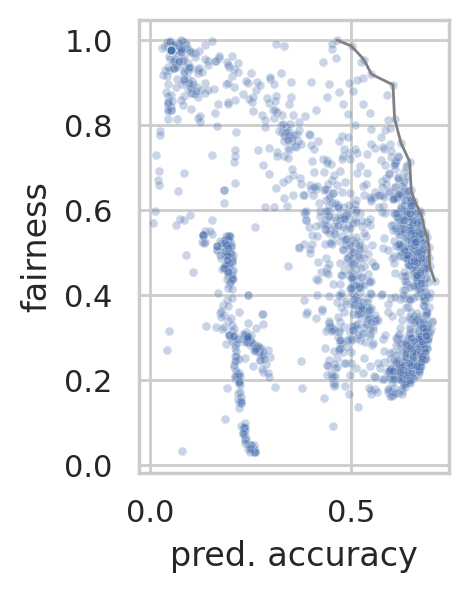

In [24]:
sns.scatterplot(
    x='performance_val', y='fairness_val',
    data=models_at_full_budget,
    alpha=0.3, s=10,
)

"""
sns.regplot(
    x='performance', y='fairness',
    data=models_at_full_budget,
    scatter=False, label='linear regression',
    color=palette[1],
    line_kws={'lw': 1}
)
"""

# Best settings for Adult dataset
if DATASET == 'Adult':
    plt.ylim(0.4, 1.01)
    plt.xlim(0.73, 1.01)
if DATASET == 'Donors Choose':
    plt.xlim(0.22, 0.64)
    plt.ylim(0, 1.03)
if DATASET == 'COMPAS':
    plt.xlim(0.4, 0.81)


# Pareto frontier
sns.lineplot(
    x=pareto_points[:,0],
    y=pareto_points[:,1],
    markers=True,
    color='grey',
    #label='Pareto frontier',
    linewidth=1,
)

# Fairness-blind rectangle region
# TODO

plt.xlabel('pred. accuracy')
plt.ylabel('fairness')

path = IMGS_DIR / f'{DATASET}_fairness_vs_performance.png'
plt.gcf().set_size_inches((2,3))
plt.gcf().savefig(path, dpi=DPI, bbox_inches="tight")
plt.show()

## Fairness vs. Accuracy; 1st page trade-off plot
- for use w/ **Adult** dataset

In [25]:
if DATASET == 'Adult':
    models_at_full_budget = pd.read_csv(ROOT_DIR / 'data' / 'Adult_models-at-full-budget_first-page-tradeoff.csv')
else:
    models_at_full_budget = all_tuner_iters_evals[
        (all_tuner_iters_evals['ri'] == 100) | (all_tuner_iters_evals['ri'].isna())
    ].copy()
    models_at_full_budget['performance'] = models_at_full_budget['performance_val']
    models_at_full_budget['fairness'] = models_at_full_budget['fairness_val']    

In [26]:
points = models_at_full_budget[['performance', 'fairness']].to_numpy()
pareto = is_pareto_efficient(1-points)
pareto_points = points[pareto]

In [27]:
if DATASET == 'Adult':
    alpha = 0.88
else:
    alpha = 0.8

In [28]:
best_perf_idx = models_at_full_budget['performance'].argmax()
best_perf_row = models_at_full_budget.iloc[best_perf_idx]

alpha_metric = models_at_full_budget['performance'] * alpha + models_at_full_budget['fairness'] * (1 - alpha)
best_tradeoff_idx = alpha_metric.argmax()
best_tradeoff_row = models_at_full_budget.iloc[best_tradeoff_idx]

In [29]:
TOP_PCT = 0.1  # top 10%
sorted_indices = models_at_full_budget['performance'].to_numpy().argsort()
top_perf_models = models_at_full_budget.iloc[sorted_indices[int(len(sorted_indices)*(1-TOP_PCT)+0.5):]]

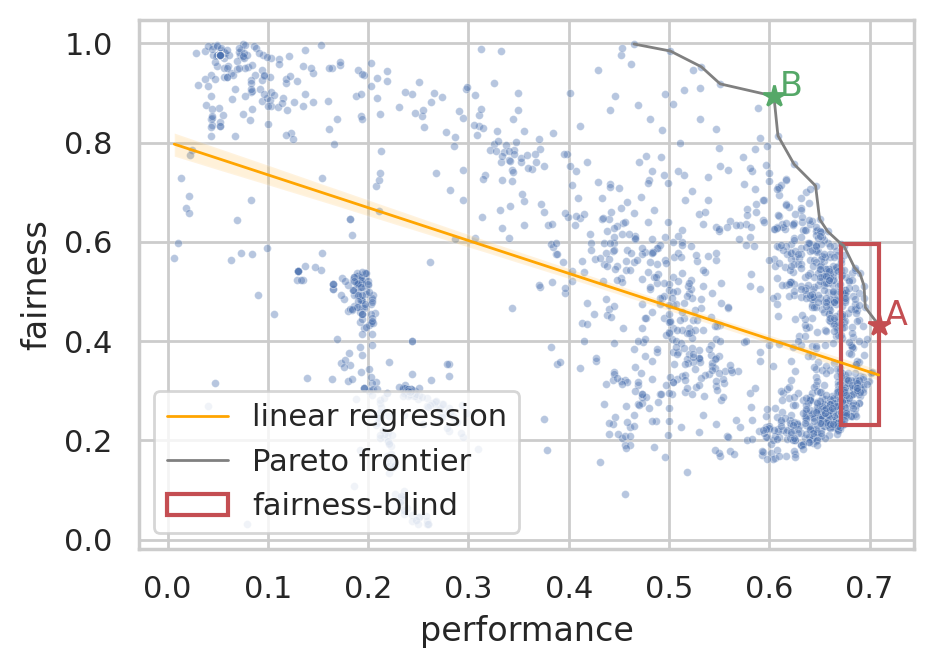

In [30]:
# Scatter plot
sns.scatterplot(
    x='performance', y='fairness',
    data=models_at_full_budget,
    alpha=0.4, s=8,
)

# Linear regression
sns.regplot(
    x='performance', y='fairness',
    data=models_at_full_budget,
    scatter=False, label='linear regression',
    color='orange',
    line_kws={'lw': 1}
)

# Pareto frontier
sns.lineplot(
    x=pareto_points[:,0],
    y=pareto_points[:,1],
    markers=True,
    color='grey',
    label='Pareto frontier',
    linewidth=1,
)


offset = 0.006
# Markers for best performing model (A)
plt.plot(
    best_perf_row.performance,
    best_perf_row.fairness,
    'r*',
    markersize=8,
)
plt.text(
    x=best_perf_row.performance + offset,
    y=best_perf_row.fairness,
    s='A', color='r',
)

# Marker for best trade-off model (B)
plt.plot(
    best_tradeoff_row.performance,
    best_tradeoff_row.fairness,
    'g*',
    markersize=8,
)
plt.text(
    x=best_tradeoff_row.performance + offset,
    y=best_tradeoff_row.fairness,
    s='B', color='g',
)

# Fairness-blind rectangle region
from matplotlib.patches import Rectangle
rec = Rectangle(
    xy=(top_perf_models['performance'].min(), top_perf_models['fairness'].min()),
    width=top_perf_models['performance'].max() - top_perf_models['performance'].min(),
    height=top_perf_models['fairness'].max() - top_perf_models['fairness'].min(),
    color='r', fill=False,
    lw=1.5,
    label='fairness-blind',
)
plt.gca().add_patch(rec)


# Settings per dataset
if DATASET == 'Adult':
    plt.ylim(0.4, 1.01)
    plt.xlim(0.7, 1.01)
    plt.xlabel('predictive accuracy (precision)')
    plt.ylabel('fairness (equal opportunity)')
elif DATASET == 'Donors Choose':
    plt.xlim(0.22, 0.64)
    plt.ylim(0, 1.03)
elif DATASET == 'COMPAS':
    plt.xlim(0.4, 0.81)
    plt.ylim(0.2, 1.01)

plt.legend(loc='lower left')

plt.gcf().set_size_inches((5, 3.5))
plt.gcf().savefig(f'{IMGS_DIR}/{DATASET}_intro_tradeoff.png', dpi=DPI)
plt.show()

## FB-auto Pareto density heatmap
- for illustration only
- GitHub data is used in the papers

In [31]:
fb_iter_evals = all_tuner_iters_evals[all_tuner_iters_evals['tuner'] == 'FB-auto'].copy()

In [32]:
PARETO_COL = 'is pareto?'
fb_iter_evals[PARETO_COL] = False

for run in range(N_RUNS):
    run_df = fb_iter_evals.iloc[run*206 : (run+1) * 206]
    costs = 1 - run_df[['performance_val', 'fairness_val']].to_numpy()
    pareto_points = is_pareto_efficient(costs)
    run_df.loc[pareto_points, PARETO_COL] = True

    # Pareto frontier plots per run
    """
    sns.scatterplot(
        data=run_df, x='performance_val', y='fairness_val',
        style=PARETO_COL, size=PARETO_COL, size_order=[True, False],
        sizes=(10, 30)
    )
    sns.lineplot(data=run_df[run_df[PARETO_COL]], x='performance_val', y='fairness_val')
    plt.show()
    """

/home/andre.cruz/miniconda3/envs/tmp/lib/python3.8/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [33]:
fb_iter_evals.value_counts(PARETO_COL)

is pareto?
False    2950
True      140
dtype: int64

In [34]:
pareto_density = fb_iter_evals.groupby(['si', 'i'])[PARETO_COL].mean().unstack()

In [35]:
# Set in same format as Hyperband Table!
pareto_density = pareto_density.iloc[::-1].transpose()

pareto_density.index = pareto_density.index.astype(int)
pareto_density.columns = pareto_density.columns.astype(int)
pareto_density

si,4,3,2,1,0
i,,,,,
0,0.028807,0.015686,0.022222,0.025,0.186667
1,0.022222,0.042424,0.080000,0.400,NaN
2,0.029630,0.133333,0.600000,NaN,NaN
3,0.222222,0.466667,NaN,NaN,NaN
4,0.333333,NaN,NaN,NaN,NaN


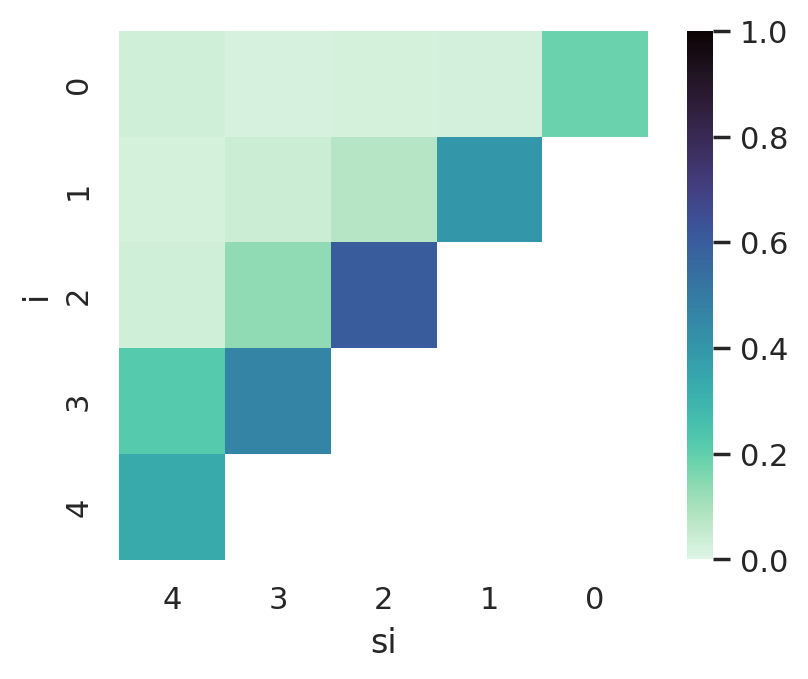

In [36]:
sns.heatmap(
    pareto_density, square=True, cbar=True,
    cmap=sns.cm.mako_r, vmin=0, vmax=1,
)

plt.gcf().savefig(
    f'{IMGS_DIR}/{DATASET}_validation_FB_heatmap_pf_density.png',
    dpi=DPI,
    bbox_inches="tight",
)
plt.show()